In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import fancyimpute
%matplotlib inline



Using TensorFlow backend.


In [2]:
# 1.reading in data
%pwd


'D:\\Python\\DataScience\\DataScience6105\\Assignment2'

In [2]:
# set path
path = 'D:\\Python\\DataScience\\DataScience6105\\Assignment2'


In [3]:
df_raw = pd.read_csv(f'{path}/train.csv',parse_dates = ["activation_date"])


In [4]:
# sort the values by acitivation_date column
df_raw.sort_values(by = "activation_date",inplace = True)
df_raw.head(3)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
751711,3b896605f03c,9457abfa0ebf,Самарская область,Самара,Личные вещи,Детская одежда и обувь,Для мальчиков,Верхняя одежда,86-92 см (1-2 года),Зимний комбенизон,Зимний комбенизон для малыша,500.0,12,2017-03-15,Private,a805aa774699aca42e538e1626ef70f806dd38d1bf85eb...,1008.0,0.0
889369,c81c34d3aac5,0b161da2b144,Иркутская область,Братск,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки,NaN,Чехол для айфона 6s,Твёрдый пластик,100.0,5,2017-03-15,Private,76c39c52a894c51499da3ee2ddecd98da533ccbdae5096...,2909.0,0.0
175952,a8ab6225dd06,93d527a1ca66,Пермский край,Краснокамск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,44–46 (M),Продам кожанную куртку,NaN,1500.0,32,2017-03-15,Private,d7cb3c4a84ce9f95958f2995474140b28ae7ad1cd0d6de...,527.0,0.0


In [5]:
# 2. Define functions for this machine learning exerise
'''Define functions to preprocess data - split dates, categorize, impute'''

def split_dates(df,date_column):
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
              "month": df[date_column].dt.month,
              "day": df[date_column].dt.day,
              "dayofyear": df[date_column].dt.dayofyear,
              "week": df[date_column].dt.week,
              "weekofyear": df[date_column].dt.weekofyear,
              "dayofweek": df[date_column].dt.dayofweek,
              "weekday": df[date_column].dt.weekday,
              "quarter": df[date_column].dt.quarter,
             })
    df = df.drop(date_column,axis = 1)
    df = pd.concat([df,date_df],axis = 1)
    return df

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res



In [15]:
# 3. Preprocess train data using the defined functions
'''
preprocess the data
''' 
df_raw_1 = split_dates(df_raw,"activation_date")
df_raw_1.head(3)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,deal_probability,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
751711,3b896605f03c,9457abfa0ebf,Самарская область,Самара,Личные вещи,Детская одежда и обувь,Для мальчиков,Верхняя одежда,86-92 см (1-2 года),Зимний комбенизон,...,0.0,2017,3,15,74,11,11,2,2,1
889369,c81c34d3aac5,0b161da2b144,Иркутская область,Братск,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки,NaN,Чехол для айфона 6s,...,0.0,2017,3,15,74,11,11,2,2,1
175952,a8ab6225dd06,93d527a1ca66,Пермский край,Краснокамск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,44–46 (M),Продам кожанную куртку,...,0.0,2017,3,15,74,11,11,2,2,1


In [16]:
df_raw_2 = str_to_cat(df_raw_1)
df_raw_2.head(3)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,deal_probability,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
751711,3b896605f03c,9457abfa0ebf,Самарская область,Самара,Личные вещи,Детская одежда и обувь,Для мальчиков,Верхняя одежда,86-92 см (1-2 года),Зимний комбенизон,...,0.0,2017,3,15,74,11,11,2,2,1
889369,c81c34d3aac5,0b161da2b144,Иркутская область,Братск,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки,NaN,Чехол для айфона 6s,...,0.0,2017,3,15,74,11,11,2,2,1
175952,a8ab6225dd06,93d527a1ca66,Пермский край,Краснокамск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,44–46 (M),Продам кожанную куртку,...,0.0,2017,3,15,74,11,11,2,2,1


In [8]:
df_raw_3,my_table = mydf_preprocessor(df_raw_2,null_table = None)
df_raw_3.head(3)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,price_na,image_top_1_na
751711,348938,447528,18,1301,5,11,110,122,186,261804,...,3,15,74,11,11,2,2,1,False,False
889369,1175228,33441,7,232,1,42,41,262,0,754605,...,3,15,74,11,11,2,2,1,False,False
175952,991010,446030,16,729,5,30,126,122,144,562387,...,3,15,74,11,11,2,2,1,False,False


In [10]:
'''Define functions to split data, measure accuracy, and r-squared'''
def split_df(df,num):
    return df[ :num].copy(),df[num: ].copy()

def my_rmse(y1,y2):
    return np.sqrt(((y1-y2)**2).mean())

def rsq_n_rmse(my_model,x_train,y_train,x_val,y_val):
    result = [my_model.score(x_train,y_train),my_model.score(x_val,y_val),
             my_rmse(my_model.predict(x_train),y_train),my_rmse(my_model.predict(x_val),y_val)]
    return "train rsq,val rsq,train rmse, val rmse", result

# use a subset to tune hyperparamters

In [11]:
x = df_raw_3.drop('deal_probability', axis=1)
y = df_raw_3['deal_probability']
x_sub,_ = split_df(x,200000)
y_sub,_ = split_df(y,200000)
x_trn,x_val = split_df(x_sub,150000)
y_trn,y_val = split_df(y_sub,150000)

# 4. Model building, hyperparameter tuning, and exploratory data analysis (EDA)

In [12]:
# build the model
mod_1 = RandomForestRegressor(n_jobs = -1,oob_score = False,n_estimators = 50, max_depth = 40000,min_samples_leaf = 25)
mod_1.fit(x_trn,y_trn)
rsq_n_rmse(mod_1,x_trn,y_trn,x_val,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.3427053635079521,
  0.20310584892504635,
  0.21036565313971112,
  0.23242936249000648])

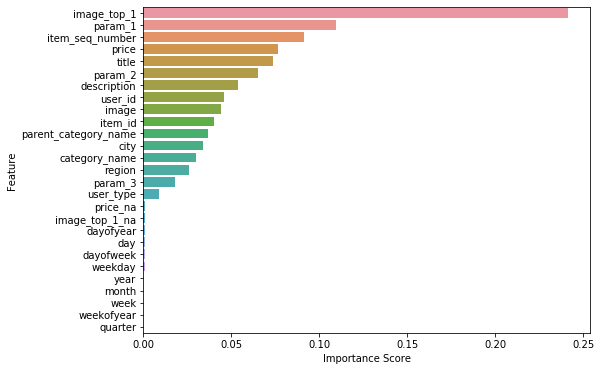

In [13]:
'''Calculate feature importance scores with your model'''

feat_imps = pd.DataFrame(mod_1.feature_importances_, index = x_trn.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [17]:
# 5. Test out your model
# preprocess the test data
test_raw = pd.read_csv(f'{path}/test.csv',parse_dates = ["activation_date"])
test_raw_1 = split_dates(test_raw,"activation_date")
test_raw_2 = str_to_cat(test_raw_1)
test_raw_2.head(3)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,image_top_1,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,...,2020.0,2017,4,18,108,16,16,1,1,2
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,...,NaN,2017,4,16,106,15,15,6,6,2
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,...,2960.0,2017,4,17,107,16,16,0,0,2


In [18]:
test_raw_3,my_table_1 = mydf_preprocessor(test_raw_2,null_table = my_table)
y_test_pred = mod_1.predict(test_raw_3)
print(y_test_pred)


[0.13608164 0.250482   0.14887222 ... 0.05443806 0.28518139 0.09810532]


In [9]:
def mydf_imputer_fancy_inpute_KNN(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum():
            my_df[null_status+'_na'] = pd.isnull(feature)

def mydf_preprocessor_fancy_inpute_KNN(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer_fancy_inpute_KNN(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res


In [14]:
df_raw_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503424 entries, 751711 to 187627
Data columns (total 28 columns):
item_id                 1503424 non-null int32
user_id                 1503424 non-null int32
region                  1503424 non-null int8
city                    1503424 non-null int16
parent_category_name    1503424 non-null int8
category_name           1503424 non-null int8
param_1                 1503424 non-null int16
param_2                 1503424 non-null int16
param_3                 1503424 non-null int16
title                   1503424 non-null int32
description             1503424 non-null int32
price                   1503424 non-null float64
item_seq_number         1503424 non-null int64
user_type               1503424 non-null int8
image                   1503424 non-null int32
image_top_1             1503424 non-null float64
deal_probability        1503424 non-null float64
year                    1503424 non-null int64
month                   1503424 non

In [18]:
df_test_raw = df_raw_2.drop(["item_id","user_id","region","city","parent_category_name","category_name","param_1","param_2","param_3","title","description","user_type","image","deal_probability","year","month","day","item_seq_number","dayofyear","week","weekofyear","dayofweek","weekday","quarter","price"],axis=1)
df_test_Raw = df_raw_2.drop(["item_id","user_id","region","city","parent_category_name","category_name","param_1","param_2","param_3","title","description","user_type","image","deal_probability","year","month","day","item_seq_number","dayofyear","week","weekofyear","dayofweek","weekday","quarter","image_top_1"],axis=1)


In [12]:
'''
using the fancyimpute to impute the data
'''
# the missing imputation is filled with 0
df_test_raw_1 = df_test_raw[:5000]
df_test = fancyimpute.KNN(k=3).fit_transform(df_test_raw_1)


Imputing row 1/5000 with 0 missing, elapsed time: 3.170
Imputing row 101/5000 with 0 missing, elapsed time: 3.171
Imputing row 201/5000 with 0 missing, elapsed time: 3.171
Imputing row 301/5000 with 0 missing, elapsed time: 3.171
Imputing row 401/5000 with 0 missing, elapsed time: 3.172
Imputing row 501/5000 with 0 missing, elapsed time: 3.172
Imputing row 601/5000 with 0 missing, elapsed time: 3.172
Imputing row 701/5000 with 0 missing, elapsed time: 3.173
Imputing row 801/5000 with 0 missing, elapsed time: 3.173
Imputing row 901/5000 with 0 missing, elapsed time: 3.173
Imputing row 1001/5000 with 0 missing, elapsed time: 3.174
Imputing row 1101/5000 with 1 missing, elapsed time: 3.174
Imputing row 1201/5000 with 0 missing, elapsed time: 3.174
Imputing row 1301/5000 with 0 missing, elapsed time: 3.175
Imputing row 1401/5000 with 0 missing, elapsed time: 3.175
Imputing row 1501/5000 with 0 missing, elapsed time: 3.175
Imputing row 1601/5000 with 1 missing, elapsed time: 3.176
Imputing 

In [19]:
df_test_Raw_1 = df_test_Raw[:5000]
df_Test = fancyimpute.KNN(k=3).fit_transform(df_test_Raw_1)


Imputing row 1/5000 with 0 missing, elapsed time: 3.200
Imputing row 101/5000 with 0 missing, elapsed time: 3.201
Imputing row 201/5000 with 0 missing, elapsed time: 3.202
Imputing row 301/5000 with 0 missing, elapsed time: 3.203
Imputing row 401/5000 with 0 missing, elapsed time: 3.203
Imputing row 501/5000 with 0 missing, elapsed time: 3.204
Imputing row 601/5000 with 1 missing, elapsed time: 3.205
Imputing row 701/5000 with 0 missing, elapsed time: 3.206
Imputing row 801/5000 with 0 missing, elapsed time: 3.206
Imputing row 901/5000 with 0 missing, elapsed time: 3.207
Imputing row 1001/5000 with 0 missing, elapsed time: 3.208
Imputing row 1101/5000 with 0 missing, elapsed time: 3.208
Imputing row 1201/5000 with 0 missing, elapsed time: 3.209
Imputing row 1301/5000 with 0 missing, elapsed time: 3.209
Imputing row 1401/5000 with 0 missing, elapsed time: 3.210
Imputing row 1501/5000 with 0 missing, elapsed time: 3.210
Imputing row 1601/5000 with 1 missing, elapsed time: 3.211
Imputing 

In [13]:
# BiScaler doesn't work
df_test_1 = fancyimpute.BiScaler().fit_transform(df_test_raw_1)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [14]:
df_test_2 = fancyimpute.SoftImpute().fit_transform(df_test_raw_1)


[SoftImpute] Max Singular Value of X_init = 107101.907999
[SoftImpute] Iter 1: observed MAE=24.930681 rank=1
[SoftImpute] Iter 2: observed MAE=24.930681 rank=1
[SoftImpute] Iter 3: observed MAE=24.930681 rank=1
[SoftImpute] Iter 4: observed MAE=24.930681 rank=1
[SoftImpute] Iter 5: observed MAE=24.930681 rank=1
[SoftImpute] Iter 6: observed MAE=24.930681 rank=1
[SoftImpute] Iter 7: observed MAE=24.930681 rank=1
[SoftImpute] Iter 8: observed MAE=24.930681 rank=1
[SoftImpute] Iter 9: observed MAE=24.930681 rank=1
[SoftImpute] Iter 10: observed MAE=24.930681 rank=1
[SoftImpute] Iter 11: observed MAE=24.930681 rank=1
[SoftImpute] Iter 12: observed MAE=24.930681 rank=1
[SoftImpute] Iter 13: observed MAE=24.930681 rank=1
[SoftImpute] Iter 14: observed MAE=24.930681 rank=1
[SoftImpute] Iter 15: observed MAE=24.930681 rank=1
[SoftImpute] Iter 16: observed MAE=24.930681 rank=1
[SoftImpute] Iter 17: observed MAE=24.930681 rank=1
[SoftImpute] Iter 18: observed MAE=24.930681 rank=1
[SoftImpute] It

In [20]:
df_Test_2 = fancyimpute.SoftImpute().fit_transform(df_test_Raw_1)


[SoftImpute] Max Singular Value of X_init = 111402571.303819
[SoftImpute] Iter 1: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 2: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 3: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 4: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 5: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 6: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 7: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 8: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 9: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 10: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 11: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 12: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 13: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 14: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 15: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 16: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 17: observed MAE=4846.071299 rank=1
[SoftImpute] Iter 18: observed

In [21]:
test = df_raw_2.drop(["price","image_top_1","deal_probability"],axis=1)
x = pd.concat([test, df_test, df_Test], axis=1)
y = df_test_raw['deal_probability']
x_trn_test,x_val_test = split_df(x,3500)
y_trn_test,y_val_test = split_df(y,3500)


NameError: name 'df_test' is not defined

In [22]:
mod_2 = RandomForestRegressor(n_jobs = -1,oob_score = False,n_estimators = 50, max_depth = 40000,min_samples_leaf = 25)
mod_2.fit(x_trn_test,y_trn_test)
rsq_n_rmse(mod_2,x_trn_test,y_trn_test,x_val_test,y_val_test)

NameError: name 'x_trn_test' is not defined